In [214]:
using ISOKANN
using SqraCore
using LinearAlgebra
using Plots
using StatsBase

In [215]:
rownormalize(x; p=2) = (x ./ norm.(eachrow(x), p))

colnormalize(x; p=2) = (x ./ norm.(eachcol(x), p)')

signfirstrow(x) = x ./ sign.(x[1, :])'

normcols(x) = signfirstrow(colnormalize(x))

normcols (generic function with 1 method)

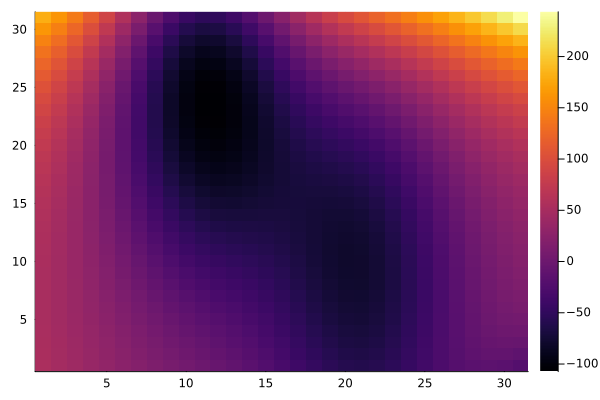

eigenvectors
1.0000000000000033 + 0.0im
0.9430773127210207 + 0.0im
0.8700923625019256 + 0.0im
0.8237203498601761 + 0.0im
0.7672824630548899 + 0.0im
0.7323826707123475 + 0.0im
0.6798770120356847 + 0.0im
0.6456165867854878 + 0.0im
0.6011951505527932 + 0.0im
0.5906826571394413 + 0.0im


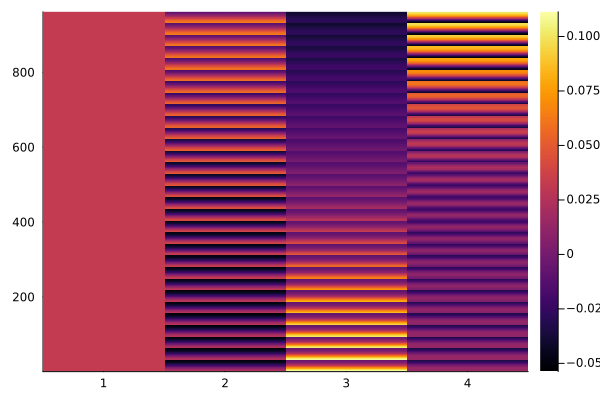

In [216]:
function generate_K_ev(M=4)

    xs = -1.5:0.05:1
    ys = -0.5:0.05:1
    pot = [ISOKANN.mueller_brown(x, y) for x in ys, y in ys]

    Plots.heatmap(pot) |> display

    Q = sqra_grid(pot, beta=0.02)
    K = exp(collect(Q) .* 0.1)
    vals = eigen(K, sortby=x -> real(-x)).values[1:10]
    println("eigenvectors")
    println.(vals)

    eigenvecs = eigen(K, sortby=x -> real(-x)).vectors

    ev = eigenvecs[:, 1:M] |> real |> signfirstrow
    heatmap(ev) |> display
    K, ev
end

K, ev = generate_K_ev();

In [277]:
function generate_LR(;eta = 0.001, K=K, n=10, orthogonal = false)
    L = randn(size(ev)) |> normcols

    for i in 1:n-1
        L = K * L
        L = normcols(L + randn(size(L)) * eta)
        if orthogonal
            q, r = qr(L)
            L = q[:, 1:4]
        end
    end
    R = K*L
    
    
    #@show norm(L), norm(R)
    L, R
end
L, R = generate_LR()

([0.012858854366359413 0.011028452985549688 0.09484362859261579 0.0358975361044091; 0.013254678853584102 0.009715205937866246 0.09653935497369232 0.036058747833353756; … ; 0.05143992332374699 0.02917687566503631 -0.0354384921222904 0.03240047429031473; 0.05070362206257115 0.029379026487819284 -0.03410217624320648 0.034449896899805994], [0.016189992990567982 0.0077443566724227485 0.08162877241745509 0.03523894060339168; 0.016393308599131858 0.007808055512139328 0.08090368645503285 0.03482547552801681; … ; 0.046661095566322246 0.029223223606122693 -0.0323718076447816 0.029104989565728226; 0.04718213364531607 0.02992167540193375 -0.032581309004876 0.029301105293899444])

In [240]:
function pi1(L, R)
    x = L'
    y = R'

    @assert size(x, 1) < size(x, 2)
    kinv = x * pinv(y)
    e = eigen(kinv)
    #@show 1 ./ e.values
    Q = e.vectors
    target_pi1 = (inv(Q) * y)'
    target_pi1 = normcols(target_pi1)
end

target_pi1 = pi1(L, R);

In [241]:
function pi2(L, R)
    x = L'
    y = R'

    @assert size(x, 1) < size(x, 2)
    k = y * pinv(x)
    e = eigen(k)
    #@show e.values[end:-1:1]
    Q = e.vectors[:, end:-1:1] |> real

    target_pi2 = (Q * y)'
    target_pi2 = normcols(target_pi2);
end

target_pi2 = pi2(L, R);

In [242]:
# these are all the same
pinv(L) * R
L \ R
R' / L'
R' * pinv(L');

In [243]:
function lr1(L, R)
    @assert size(L, 1) > 100
    M = size(L, 2)

    # compute qr basis of LR space -- q is basis, r are components
    LR = hcat(R, L)
    q,r = qr(LR)
    @assert q[:, 1:8] * r ≈ LR

    D = size(L, 2)
    # representation of image and preimage in that basis
    qR = r[:, 1:D]
    qL = r[:, D+1:end]

    # estimate map in this space
    A = qL * pinv(qR)
    e = eigen(A)
    #@show e.values
    Q = e.vectors

    # project eigenvectors back to original space
    t = q * Q
    return normcols(t[:, M+1:end])
end

target_lr1 = lr1(L, R);

In [244]:
function lr2(L, R)
    @assert size(L, 1) > 100
    M = size(L, 2)

    # compute qr basis of LR space -- q is basis, r are components
    LR = hcat(R, L)
    q, r = qr(LR)
    @assert q[:, 1:8] * r ≈ LR

    D = size(L, 2)
    # representation of image and preimage in that basis
    qR = r[:, 1:D]
    qL = r[:, D+1:end]

    # estimate map in this space
    A = qR * pinv(qL)
    e = eigen(A)
    #@show e.values
    Q = e.vectors

    # project eigenvectors back to original space
    t = q * Q[:, end:-1:M+1]
    return normcols(t)
end

target_lr2 = lr2(L, R);

In [245]:
mapreduce(hcat, [target_lr1, target_lr2, target_pi1, target_pi2, R]) do x
    x = normcols(x)
    norm.(eachcol(x .- ev))
end


4×5 Matrix{Float64}:
 0.118233  0.0951001  0.0965264  1.63638  0.527237
 0.107257  0.0898101  0.0964307  1.70991  1.14643
 0.639175  0.595896   0.60644    1.45655  1.31751
 1.23991   1.25894    1.26513    1.39319  1.5457

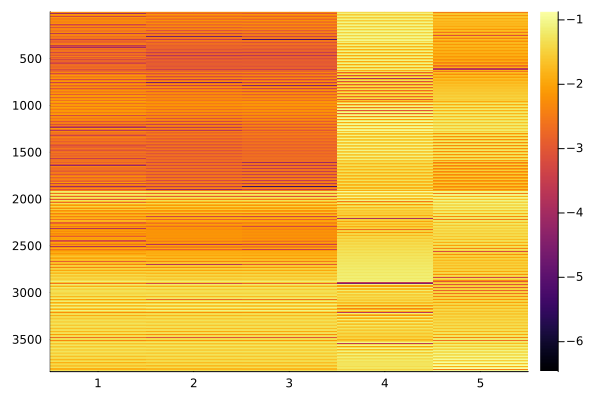

In [246]:
heatmap(([vec(target_lr1) vec(target_lr2) vec(target_pi1) vec(target_pi2) vec(normcols(R))] .- vec(ev)) .|> abs .|> log10, yflip=true)

In [250]:
function benchmark(;eta = 0.001, n=5, m=1000)
    es = mapreduce(vcat, 1:m) do x
        L, R = generate_LR(;eta, n)
        target_lr1 = lr1(L,R)
        target_lr2 = lr2(L,R)
        target_pi1 = pi1(L,R)
        target_pi2 = pi2(L,R)

        e = mapreduce(hcat, [target_lr1, target_lr2, target_pi1, target_pi2, R]) do x
            x = normcols(x)
            norm.(eachcol(x .- ev))
        end
        sum(e, dims=1)
    end
end
es = benchmark()
[mean(es, dims=1)
median(es, dims=1)
std(es, dims=1)]



3×5 Matrix{Float64}:
 4.00858  3.86489  3.79515  4.98262   5.02805
 3.94152  3.77786  3.71476  5.01259   5.04418
 1.12285  1.11934  1.12314  0.793508  0.739297

In [271]:
function benchmark(; eta=0.001, n=5, m=100, orthogonal=false)
    es = mapreduce(vcat, 1:m) do x
        L, R = generate_LR(; eta, n, orthogonal)
        target_lr1 = lr1(L, R)
        target_lr2 = lr2(L, R)
        target_pi1 = pi1(L, R)
        target_pi2 = pi2(L, R)

        e = mapreduce(hcat, [target_lr1, target_lr2, target_pi1, target_pi2, R]) do x
            x = normcols(x)
            norm.(eachcol(x .- ev))
        end
        sum(e, dims=1)
    end
end
es = benchmark()
[mean(es, dims=1)
    median(es, dims=1)
    std(es, dims=1)]



3×5 Matrix{Float64}:
 3.96231  3.83478  3.74216  4.92778   4.94634
 3.87944  3.78584  3.65322  5.01134   5.0887
 1.14281  1.10643  1.08123  0.836379  0.852501

In [268]:
function generate_LR_hist(; eta=0.001, K=K, n=10, orthogonal=false)
    L = randn(size(ev)) |> normcols
    Ls = similar(L, size(L)..., n)
    Rs = similar(R, size(L)..., n)

    for i in 1:n
        if orthogonal
            q, r = qr(L)
            L = q[:, 1:size(L, 2)]
        end

        L = normcols(L)
        
        R = K * L

        Ls[:, :,  i] = L
        Rs[:, :, i] = R
        
        L = R + randn(size(R)) * eta
    end
    return Ls, Rs
end
Ls, Rs = generate_LR_hist()

([0.04050329237532296 0.08710148109725552 0.058528681032859416 0.034509230600993174; 0.0007035526509181167 -0.0029439314676017263 -0.03492433458027179 -0.0026125609444637623; … ; 0.03796613783011777 0.032457416446948 0.03355097125512565 -0.018966568412777645; 0.0459581273775609 -0.035683087692157174 0.024094613480341146 0.04136518623511571;;; 0.036441114175649984 0.06696530363065739 0.018584954179854746 0.007453601502202842; 0.03747227946022295 0.06447416435415544 0.02323167832871767 0.008012286608705524; … ; 0.012074554110559042 -0.021173486513553354 0.008267238618037399 -0.028681383498743364; 0.01263388023932866 -0.016594140759294607 0.02375811560711583 -0.029575314462853903;;; 0.01958356158034814 0.04952349290987088 0.0018795583343771017 0.00614390949463508; 0.016420161718022335 0.05129499488875028 0.0004273885547119634 0.006043842465892332; … ; 0.005433629389428347 -0.027481548896884374 0.020505220025803836 -0.05958676793624905; 0.004238198719373209 -0.02675799367364876 0.019688783

In [284]:
eta = 0.01
n = 10
m = 100
orthogonal = false
hist = false

function benchmark_hist(; eta=eta, n=n, m=m, orthogonal=orthogonal, hist=hist)
    es = mapreduce(vcat, 1:m) do x
        if hist
            Ls, Rs = generate_LR_hist(; eta, n, orthogonal)
            L = Ls[:,:,end]
            R = Rs[:,:,end]
        else
            L, R = generate_LR(;eta,n,orthogonal)
        end
        target_lr1 = lr1(L, R)
        target_lr2 = lr2(L, R)
        target_pi1 = pi1(L, R)
        target_pi2 = pi2(L, R)

        e = mapreduce(hcat, [target_lr1, target_lr2, target_pi1, target_pi2, R]) do x
            x = normcols(x)
            norm.(eachcol(x .- ev))
        end
        sum(e, dims=1)
    end
end
for hist in [true, false]
    let es = benchmark_hist(;hist)
    [mean(es, dims=1)
        median(es, dims=1)
        std(es, dims=1)] |> display
    end
end

3×5 Matrix{Float64}:
 3.52797   3.32264  2.53068   4.83909   4.86087
 3.26816   3.15234  2.39995   4.815     4.83265
 0.906239  1.18855  0.980652  0.935164  0.819598

3×5 Matrix{Float64}:
 3.67271   3.38059  2.67449  4.6636    4.79315
 3.49584   3.34313  2.40937  4.7125    4.66242
 0.922402  1.02683  1.19519  0.885726  0.817249

In [286]:
Ls, Rs = generate_LR_hist(; eta, n, orthogonal)

([0.009120920071008258 0.013370010910701589 0.03542743800718684 0.019108432147246144; -0.038039952187611074 0.041986871586365 -0.05475572914475803 -0.04857924052975396; … ; -0.027400410895273966 -0.006785757402800152 0.05356712410049725 -0.01871500735710369; 0.052944614918524834 0.01621782573507075 0.05876674542950664 -0.03520945833431676;;; 0.044459503370968254 0.02746547556470822 0.011221138944153311 0.023975378145486222; 0.001520377892562196 0.05612331528942414 -0.012903925635969699 0.0031930279609592525; … ; 0.0028946958322760715 0.0239829955320789 -0.0006805801252083209 0.007099241156874145; 0.002592168183626203 0.03869829263222705 -0.03612644308287249 0.011408357849621466;;; 0.009049616284687829 0.012116466044484157 0.03630007576514952 0.041040554317042365; 0.02418488726213262 -0.03247843997161403 -0.01044418793198848 0.02965237667668237; … ; 0.001111321349265482 -0.0007178086083206542 -0.04665857206087318 0.05179064665508902; 0.0064752791250704605 0.002316055599483475 -0.0213434

In [303]:

mergehist(Ls) = reshape(Ls[:,:,end:-1:1], size(Ls,1), :)
lr1(mergehist(Ls), mergehist(Rs))

DimensionMismatch: DimensionMismatch: A has dimensions (961,8) but B has dimensions (80,80)

In [304]:
mergehist(Rs)

961×40 Matrix{Float64}:
  0.0331443   0.0348228   -0.012913   …  -0.00181533   -0.000373195
  0.0325107   0.0343924   -0.0132218     -0.00144366   -0.000118373
  0.031249    0.0336022   -0.0137791     -0.000914894   0.000446861
  0.0293604   0.0325642   -0.0145003     -0.000535716   0.0013542
  0.0268537   0.0314037   -0.0153141     -0.000538759   0.00252183
  0.0237698   0.0302392   -0.016184   …  -0.000953444   0.00373584
  0.0202084   0.0291734   -0.0171079     -0.00158733    0.0047196
  0.0163355   0.0282887   -0.018102      -0.00213005    0.00524648
  0.0123587   0.027642    -0.0191804     -0.00231874    0.00523314
  0.00847916  0.0272589   -0.0203383     -0.00206862    0.00476975
  ⋮                                   ⋱                
 -0.0454555   0.00999276  -0.0437294      0.00638752   -0.00347022
 -0.0483714   0.00946943  -0.0450853      0.00542894   -0.00385997
 -0.0508033   0.00911857  -0.04636        0.00451583   -0.00394202
 -0.0527968   0.00890141  -0.0475227  …   0.0037